In [1]:
import time

import torch
import torch.nn as nn
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import numpy as np

from stabnode.node import FTerm, GTerm, set_global_seed, StabNODE
from data.hysteresis import simulate_steady_state
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
seed = 1234
set_global_seed(seed = seed)

# Simple hysteresis learning

In [3]:
lam_start = -1 
lam_end = 1

n_points = 250

lam_increase = np.linspace(lam_start,lam_end, n_points)
lam_decrease = np.linspace(lam_end, lam_start, n_points)

In [4]:
x0=-1

simulate_time = (0.,50.)

x_increase = simulate_steady_state(lam_increase, x0, simulate_time)
x_decrease = simulate_steady_state(lam_decrease, x_increase[-1],simulate_time)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

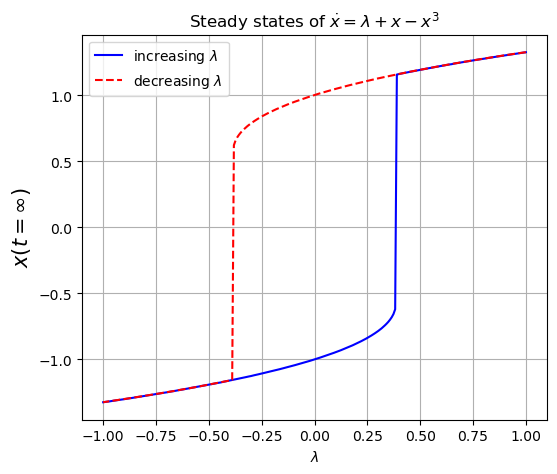

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_increase, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_decrease, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

# Stabnode learning

In [6]:
X = np.hstack((x_increase, x_decrease))
lam = np.hstack((lam_increase, lam_decrease))
repeat = 2

for _ in range(repeat):
    X = np.hstack((X,X))
    lam = np.hstack((lam, lam))

tau = torch.arange(0,len(lam),device=device)
t = (tau+1)*simulate_time[-1]

In [7]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X.reshape(-1,1))
X_scaled = torch.tensor(X_scaled,dtype=torch.float32, device=device)
scaler.data_max_, scaler.data_min_

(array([1.32443915]), array([-1.32455021]))

In [8]:
sample_rate = 10
tau_train = tau[::sample_rate]
X_train = X_scaled[tau_train]
lam_train = lam[tau_train]

In [9]:
tau_train.shape

torch.Size([200])

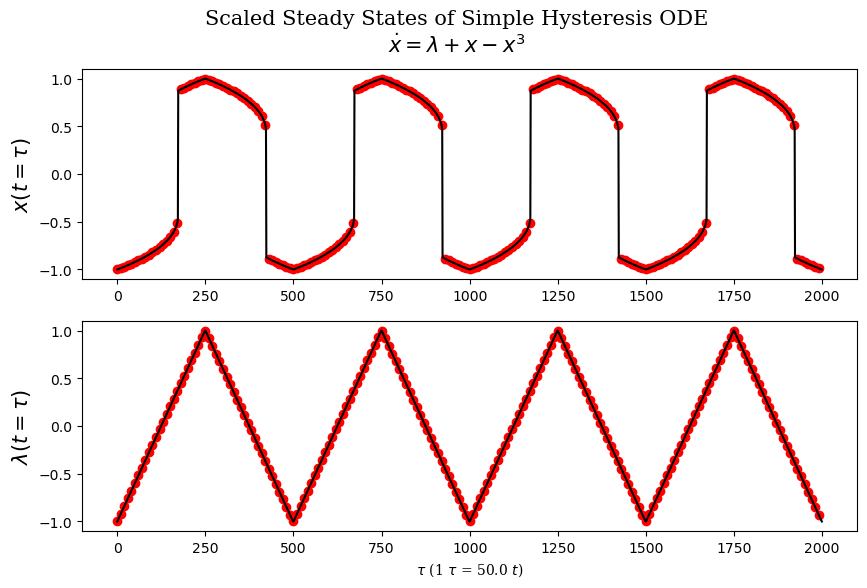

In [10]:
fig, ax = plt.subplots(2,1, figsize = (10,6))
color = 'black'

ax[0].plot(tau, X_scaled,c=color, label='True')
ax[0].scatter(tau_train, X_train,c='red', label='measurements')
ax[0].set_ylabel(r"$x(t = \tau)$",size=15, family='serif')

ax[1].plot(tau, lam,c=color)
ax[1].scatter(tau_train, lam_train,c='red')
ax[1].set_xlabel(fr"$\tau$ (1 $\tau$ = {simulate_time[-1]:.1f} $t$)",family='serif')
ax[1].set_ylabel(fr"$\lambda (t = \tau)$", family = 'serif', size=15)
plt.suptitle("Scaled Steady States of Simple Hysteresis ODE\n"+r"$\dot{x} = \lambda +x-x^3$",family='serif', size=15)
plt.show()

In [11]:
def lam_func(tau):
    idx = int(tau) % len(lam)
    return torch.tensor(lam[idx],dtype=torch.float32, device=device)

In [12]:
dim_in = X_train.shape[-1]
dim_out = X_train.shape[-1]
hidden_dim = 2

f = FTerm(dim_in, dim_out, hidden_dim )
g = GTerm(dim_in+1, dim_out, hidden_dim)

stab_node = StabNODE(f,g)
stab_node

StabNODE(
  (f): FTerm(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
  (g): GTerm(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2, out_features=1, bias=True)
      (3): Tanh()
    )
  )
)

In [13]:
list(f.parameters())+list(g.parameters())

[Parameter containing:
 tensor([[-0.9420],
         [-0.1962]], requires_grad=True),
 Parameter containing:
 tensor([-0.4803, -0.2667], requires_grad=True),
 Parameter containing:
 tensor([[-0.6247,  0.2838]], requires_grad=True),
 Parameter containing:
 tensor([-0.6339], requires_grad=True),
 Parameter containing:
 tensor([[-0.0451,  0.2458],
         [-0.2383,  0.4012]], requires_grad=True),
 Parameter containing:
 tensor([0.0892, 0.3887], requires_grad=True),
 Parameter containing:
 tensor([[ 0.4537, -0.3122]], requires_grad=True),
 Parameter containing:
 tensor([0.2570], requires_grad=True)]

In [ ]:
tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32,device=device)
x0.requires_grad_(True)
print(x0)
method = 'rk4'
# method = None
x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method=method)

In [ ]:
if torch.isnan(x_pred).any():
    print("nan")

In [15]:
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = 1e-2)

# early stopping criteria 
patience = ...
rtol = ...
print_every = 10

tau_span = tau_train.clone().detach().to(dtype=torch.float32, device=device)
x0 = X_train[0].reshape(-1, 1).clone().detach().to(dtype=torch.float32, device=device)
x0.requires_grad_(True)

n_epochs = 250
losses = []
opt_history = {}
# losses
# stop criteria - max-iterations, early-stop-atol
for epoch in tqdm(range(n_epochs)):
    t1 = time.time()
    opt.zero_grad()
    x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method='rk4')
    if torch.isnan(x_pred).any():
        print("Numerical instability. Using dopri15.")
        x_pred = odeint(lambda t, x: stab_node(t,x,lam_func), x0, tau_span, method=None)
    loss = loss_criteria(x_pred.squeeze(), X_train.squeeze())
    loss.backward()
    opt.step()
    t2 = time.time()
    losses.append(loss.item())
    if epoch <= 5 or epoch % print_every == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}, time = {t2-t1:.4f} s.")

# send modesl to cpu 
# save results
    

  0%|          | 0/250 [00:00<?, ?it/s]

Numerical instability. Using dopri15.
Epoch 0: Loss = 0.7815, time = 47.6774 s.
Numerical instability. Using dopri15.
Epoch 1: Loss = 0.7648, time = 48.4462 s.
Numerical instability. Using dopri15.
Epoch 2: Loss = 0.7489, time = 63.8929 s.
Numerical instability. Using dopri15.
Epoch 3: Loss = 0.7338, time = 66.9400 s.
Numerical instability. Using dopri15.
Epoch 4: Loss = 0.7195, time = 72.5105 s.
Numerical instability. Using dopri15.
Epoch 5: Loss = 0.7061, time = 109.9353 s.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Epoch 10: Loss = 0.6475, time = 154.0026 s.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.
Numerical instability. Using dopri15.


KeyboardInterrupt: 

In [ ]:
# losses

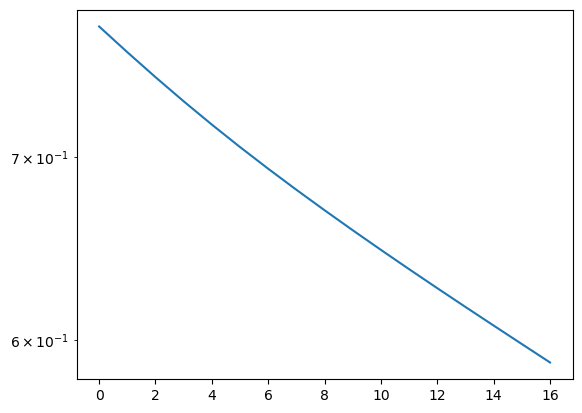

In [16]:
plt.plot(losses)
plt.yscale('log')
plt.show()

In [17]:
losses = np.array(losses)

In [18]:
losses[-10:]

array([0.68111551, 0.66947615, 0.65828943, 0.64749968, 0.63706368,
       0.62694573, 0.61710954, 0.60752106, 0.59814131, 0.58893257])

In [19]:
loss_diff = losses[1:] - losses[:-1]

In [20]:
loss_diff[-50:].min()

-0.016734540462493896

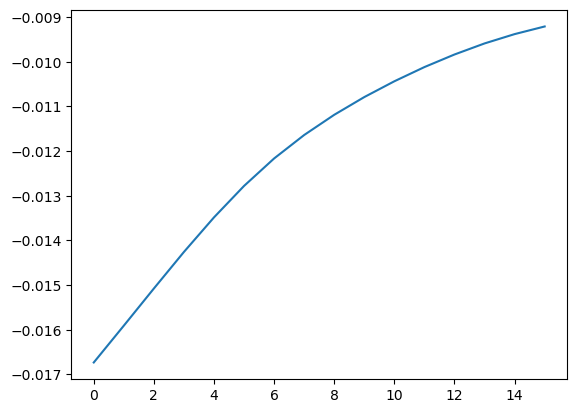

In [21]:
plt.plot(loss_diff[-20:])

# g and f outputs

In [22]:
def g_true(x,lam):
    return (1/x)*((lam / x)  + 1)

def f_true(x):
    return -x**2

In [23]:
g.eval()
f.eval()


g_true_out = []
g_pred_out = []

f_true_out = []
f_pred_out = []

for tau_i in tau:

    lam_i = lam_func(tau_i).reshape(-1,1)
    xi = X_scaled[tau_i].reshape(-1,1)
    xi_unscaled = X[tau_i].reshape(-1,1)

    g_true_out.append(g_true(xi_unscaled,lam_i.numpy()))
    f_true_out.append(f_true(xi_unscaled))

    with torch.no_grad():
        g_pred_out.append(g(xi,lam_i).detach().cpu().numpy())
        f_pred_out.append(f(xi).detach().cpu().numpy())

g_true_out = np.array(g_true_out).reshape(-1)
g_pred_out = np.array(g_pred_out).reshape(-1)

f_true_out = np.array(f_true_out).reshape(-1)
f_pred_out = np.array(f_pred_out).reshape(-1)
    

In [24]:
finite_idx = np.isfinite(g_true_out)
np.count_nonzero(~finite_idx)

0

In [25]:
g_true_scaled = scaler.transform(g_true_out[finite_idx].reshape(-1,1)).reshape(-1)

In [26]:
g_pred_out[0], x0

(-0.21622708, tensor([[-1.]], requires_grad=True))

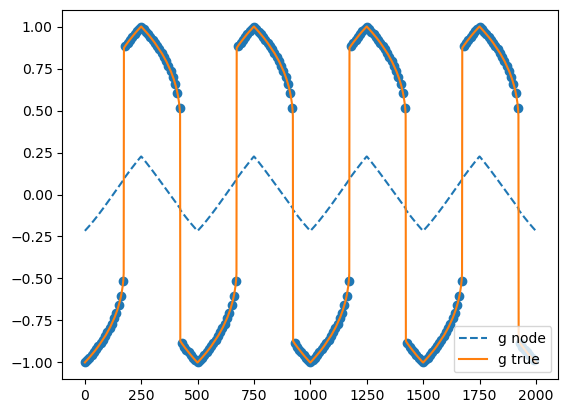

In [34]:
plt.plot(g_pred_out, linestyle='--', label='g node')
plt.plot(g_true_scaled, label='g true')
plt.scatter(tau_train, X_train)
# plt.plot(X_scaled, label='raw data')
plt.legend()
plt.show()

In [28]:
x0, tau_train[0]

(tensor([[-1.]], requires_grad=True), tensor(0))

In [29]:
X_scaled[:10]

tensor([[-1.0000],
        [-0.9988],
        [-0.9975],
        [-0.9962],
        [-0.9948],
        [-0.9931],
        [-0.9916],
        [-0.9903],
        [-0.9891],
        [-0.9873]])

In [30]:
scaler.data_max_

array([1.32443915])

In [31]:
g_true_out.max()

1.325790317927218

In [32]:
f_true_scaled = scaler.transform(f_true_out.reshape(-1,1)).reshape(-1)

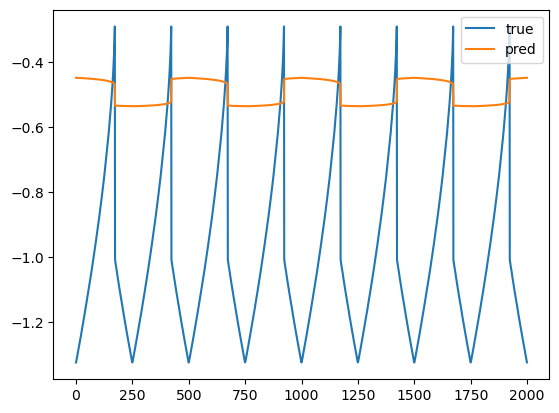

In [33]:
plt.plot(f_true_scaled,label='true')
plt.plot(f_pred_out, label='pred')
plt.legend()
plt.show()

In [ ]:
X_train[0].numpy()

In [ ]:
X_scaled[0]